In [1]:
import numpy as np
import pandas as pd

In [2]:
import skimage as sk


In [3]:
import sys
sys.path.append(r'/home/kevin/repos/ReipurthBallyProject/')

In [4]:
from src.r_d_src.coo_utils import coo2df

In [5]:
satsuki_df = coo2df(r'/home/kevin/repos/ReipurthBallyProject/SubaruCoordinateMaps/satsuki.coo')

In [6]:
satsuki_df

,x_ref,y_ref,x_in,y_in
0,1986.0542,94.003948,2004.39440,68.327594
1,1945.7056,53.655391,1960.37780,27.979037
2,1718.2865,119.680300,1732.95870,94.003948
3,1718.2865,71.995644,1729.29060,49.987341
4,1751.2989,71.995644,1765.97110,46.319290
...,...,...,...,...
75,938.1168,3801.921400,947.48534,3810.438300
76,1080.3482,3908.382000,1088.01340,3915.195500
77,1575.7865,3991.431400,1584.30330,3999.005900
78,1880.6579,4051.407400,1890.02250,4058.307600


In [7]:
src = np.array([satsuki_df.x_in, satsuki_df.y_in]).T
dst = np.array([satsuki_df.x_ref, satsuki_df.y_ref]).T

In [8]:
tran = sk.transform.estimate_transform('polynomial', src,dst, 3)

In [9]:
def rmse(resid):
    RMSE = np.sqrt((resid**2).mean())
    return RMSE

In [10]:
resid = tran.residuals(src, dst)
rmse(resid)

1.2059972935060397

In [11]:
import os
coo_maps = r'/home/kevin/repos/ReipurthBallyProject/SubaruCoordinateMaps/'
for detector in os.listdir(coo_maps):
    coo_path = os.path.join(coo_maps, detector)
    coo_df = coo2df(coo_path)
    src = np.array([coo_df.x_in, coo_df.y_in]).T
    dst = np.array([coo_df.x_ref, coo_df.y_ref]).T
    tran = sk.transform.estimate_transform('polynomial', src,dst, 3)
    resid = tran.residuals(src, dst)
    RMSE = rmse(resid)
    print(f'Detector: {detector}, Number of Points: {len(resid)}, RMSE: {RMSE}')


Detector: sophie.coo, Number of Points: 51, RMSE: 22.47747791789204
Detector: san.coo, Number of Points: 92, RMSE: 2.5453579198926146
Detector: sheeta.coo, Number of Points: 53, RMSE: 3.712878140279741
Detector: fio.coo, Number of Points: 54, RMSE: 3.8304663027083623
Detector: nausicaa.coo, Number of Points: 51, RMSE: 1.1590773423714407
Detector: chihiro.coo, Number of Points: 68, RMSE: 2.0524221611681916
Detector: ponyo.coo, Number of Points: 70, RMSE: 1.670003507736529
Detector: kiki.coo, Number of Points: 51, RMSE: 2.0682780839445742
Detector: satsuki.coo, Number of Points: 80, RMSE: 1.2059972935060397
Detector: clarisse.coo, Number of Points: 78, RMSE: 3.3100903000797772


In [12]:
for detector in ['satsuki.coo']:
    coo_path = os.path.join(coo_maps, detector)
    coo_df = coo2df(coo_path)
    src = np.array([coo_df.x_in, coo_df.y_in]).T
    dst = np.array([coo_df.x_ref, coo_df.y_ref]).T
    tran = sk.transform.estimate_transform('polynomial', src,dst, 3)
    resid = tran.residuals(src, dst)
    RMSE = rmse(resid)
    print(f'Detector: {detector}, Number of  RMSE: {RMSE}')

Detector: satsuki.coo, Number of  RMSE: 1.2059972935060397


In [13]:
resid.max(), resid.argmax()

(3.9639337757325785, 3)

In [14]:
np.allclose(np.sqrt(((dst - tran(src))**2).sum(axis=1)), resid)

True

In [15]:
def df2reg(df, regpath, x='x_in', y='y_in', radius=8, nameroot='Region'):
    reghdr =[ '# Region file format: DS9 version 4.1',
             'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
            'physical']
    x_col = 1 if x == 'x_ref' else 3
    y_col = 2 if y == 'y_ref' else 4
    with open(regpath, 'w') as reg:
        for hdr in reghdr:
            reg.write(hdr+'\n')
        for i, r in enumerate(df.itertuples()):
            title = '{' + f'{nameroot}_{i:03d}' + '}'
            circ = f'Circle({r[x_col]}, {r[y_col]}, {radius}) # text={title}'
            reg.write(circ+'\n')

        



In [16]:
detector = 'nausicaa'
coo_path = os.path.join(coo_maps, detector+'.coo')
coo_df = coo2df(coo_path)

regpath = os.path.join(r'/home/kevin/Documents/M8new/N-A-L656',detector+'.reg')

df2reg(coo_df, regpath)

In [17]:
import sep
from astropy.io import fits

In [18]:
def find_objects(unbiased_image, thresh = 3):
    with fits.open(unbiased_image) as f:
        hdr = f[0].header.copy()
        img = f[0].data.copy()
    img = img.byteswap().newbyteorder()
    bkg = sep.Background(img)
    bkg_img = bkg.back() #2d array of background

    img_noback = img - bkg
    objects = sep.extract(img_noback, thresh=thresh, err = bkg.globalrms)
    objects_df = pd.DataFrame(objects)
    return objects_df

In [19]:
img_path = r'/home/kevin/Documents/M8new/N-A-L656/no_bias/SUPA01564800.fits'
object_df = find_objects(img_path,thresh=50)


In [20]:
object_df

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
0,6641.226074,1879,1803,117,1218,0,2,513.093704,0.405470,32580.640333,...,0.001143,3.241972e+07,3.835907e+07,25895.722656,40562.605469,486,0,486,0,3
1,6641.226074,69,62,784,804,0,4,794.071296,1.303480,11.488112,...,0.064884,2.359982e+06,2.513625e+06,120495.070312,159031.296875,794,2,794,1,3
2,6641.226074,1597,1343,652,1387,0,2,975.958320,0.421026,29180.813151,...,-0.001980,2.627216e+07,3.129998e+07,32723.970703,56711.957031,1087,0,1087,0,3
3,6641.226074,474,362,0,194,0,4,63.071406,0.449424,2421.919123,...,-0.003391,6.916538e+06,8.229890e+06,28972.302734,50145.363281,1,0,0,0,3
4,6641.226074,1557,1395,1280,2047,0,3,1818.519101,0.451082,79648.466126,...,0.003883,1.728244e+07,2.132837e+07,24869.839844,38546.835938,1431,0,1431,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,6641.226074,36,35,1408,1413,4104,4110,1410.696711,4106.787589,1.866739,...,-0.061588,5.971992e+05,6.276966e+05,33402.171875,40052.625000,1411,4107,1411,4107,0
284,6641.226074,37,32,959,964,4126,4132,961.429708,4128.984497,1.870205,...,-0.037503,5.438224e+05,5.707694e+05,29572.214844,34778.433594,961,4129,961,4129,0
285,6641.226074,13,13,1941,1944,4164,4167,1942.622209,4165.332876,0.903689,...,0.295439,1.138968e+05,1.274128e+05,11422.157227,13597.765625,1943,4165,1943,4165,0
286,6641.226074,12,10,1312,1316,4174,4176,1314.139354,4175.360562,1.444880,...,0.178904,1.361073e+05,1.732873e+05,16913.484375,29250.277344,1314,4176,1314,4176,2


In [22]:
from astropy.table import Table
Table.from_pandas(object_df)

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
6641.22607421875,1879,1803,117,1218,0,2,513.0937044861028,0.40547031588103993,32580.640333067626,0.6718435460301583,-12.425323138244323,0.0011256607765709429,3.194353210229981e-08,-7.715822827945221e-07,180.5010986328125,0.8167648315429688,-0.00038137915544211864,3.091109829256311e-05,1.4990146160125732,0.001143362489528954,32419724.0,38359072.0,25895.72265625,40562.60546875,486,0,486,0,3
6641.22607421875,69,62,784,804,0,4,794.0712960062833,1.303479659414456,11.488112067094505,1.220461230092063,-0.44834186704258094,5.13002761724011e-06,3.802517934722891e-07,-1.6403735620522266e-07,3.3922929763793945,1.0958656072616577,-0.04355497285723686,0.08831260353326797,0.8312801122665405,0.06488405913114548,2359982.25,2513625.0,120495.0703125,159031.296875,794,2,794,1,3
6641.22607421875,1597,1343,652,1387,0,2,975.9583202115081,0.4210264629733451,29180.81315142807,0.6468846372030977,18.353094584076473,0.0013464357183840961,3.9920069302868755e-08,1.6991982638956703e-06,170.82395935058594,0.7970830202102661,0.000628957524895668,3.489170194370672e-05,1.5739564895629883,-0.00197986070998013,26272156.0,31299976.0,32723.970703125,56711.95703125,1087,0,1087,0,3
6641.22607421875,474,362,0,194,0,4,63.07140626676837,0.4494239157342371,2421.9191228157742,0.6909454065792604,2.8237537574683955,0.0004432007308290002,1.8229007223832315e-07,1.088268281932646e-06,49.21303176879883,0.8292479515075684,0.0011662463657557964,0.0004148725129198283,1.454221487045288,-0.0033909997437149286,6916537.5,8229890.0,28972.302734375,50145.36328125,1,0,0,0,3
6641.22607421875,1557,1395,1280,2047,0,3,1818.5191014171985,0.45108186475969403,79648.46612554597,0.43532001319424096,-60.26931393816392,0.006376674435267798,4.581719912871678e-08,-6.965727260623394e-06,282.2206726074219,0.6242712140083313,-0.0007566949934698641,1.4024402844370343e-05,2.565979480743408,0.003883309429511428,17282444.0,21328368.0,24869.83984375,38546.8359375,1431,0,1431,0,3
6641.22607421875,163,151,97,110,6,21,103.34720976166635,13.7132148934834,4.424200576568737,9.92977820293477,0.14571503149649345,2.1119692006730625e-07,2.8184442041370427e-07,1.373938755016461e-09,3.151766538619995,2.10246205329895,1.5443542003631592,0.22613883018493652,0.10075587779283524,-0.006636971607804298,12399866.0,12435247.0,202560.140625,203111.578125,103,14,103,14,0
6641.22607421875,28,25,1010,1015,151,156,1012.743443975925,153.4634547435931,1.6757534873097857,1.8999363355026713,0.007594263633074583,9.291767611942569e-06,9.63935535719893e-06,6.614152508731549e-09,1.3784749507904053,1.2944097518920898,1.5369727611541748,0.5967572927474976,0.5263429880142212,-0.004770614672452211,339667.03125,363187.8125,20434.40625,24188.27734375,1013,153,1013,153,0
6641.22607421875,11,11,402,405,234,237,403.64421586587036,235.43351548504816,0.7179830478759546,0.9261803889759275,0.06687037543980923,1.8937034707361834e-05,2.3780915552436232e-05,1.8089514455432881e-06,0.9725266098976135,0.8356766700744629,1.285298228263855,1.4022197723388672,1.0870128870010376,-0.2024809867143631,89229.21875,98697.546875,9603.7041015625,11060.2255859375,404,235,404,235,0
6641.22607421875,92,88,494,503,262,272,498.8147434267742,266.67780248316706,3.373285019365923,4.277337713541648,0.10208531064266424,6.516570467384969e-07,8.101136646035432e-07,2.4342749548807368e-08,2.0709228515625,1.8335487842559814,1.4597398042678833,0.2966611981391907,0.23395927250385284,-0.014160561375319958,4051352.25,4094655.5,160261.71875,185481.34375,499,266,499,266,0


In [23]:
reg_df = object_df[['x','y']].rename(columns={'x':'x_ref', 'y':'y_ref'})
#convert to fits (1-relative) indexing
reg_df.x_ref += 1
reg_df.y_ref += 1
df2reg(reg_df, r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\SUPA01564800.reg', x='x_ref', y='y_ref')

In [24]:
def coo2reg(coo, reg_path, nameroot='Star'):
    reghdr =[ '# Region file format: DS9 version 4.1',
            'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
        'physical']
    
    if type(coo) == str:
        coo_df = coo2df(coo_path)
    elif type(coo) == pd.DataFrame:
        coo_df = coo
    else:
        raise ValueError('Invalid coo type')

    with open(reg_path, 'w') as reg:
        for hdr in reghdr:
            reg.write(hdr+'\n')
        for i,pair in enumerate(coo_df.itertuples()):
            title = '{' + f'{nameroot}_{i:03d}' + '}'
            circ = f'Circle({pair.x_in}, {pair.y_in}, 8) # text={title}'
            reg.write(circ+'\n')
            circ = f'Circle({pair.x_ref}, {pair.y_ref}, 8) # color=blue'
            reg.write(circ+'\n')
            line = f'line( {pair.x_in}, {pair.y_in}, {pair.x_ref}, {pair.y_ref}) # line=0 1'
            reg.write(line+'\n')
    

In [25]:
coo_maps = r'C:\Users\Kevin\repos\ReipurthBallyProject\SubaruCoordinateMaps'
regpath = r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\SUPA01564800_coo.reg'
detector = 'nausicaa'
coo2reg(os.path.join(coo_maps, detector+'.coo'), regpath)

In [26]:
type(regpath) == int, type(object_df)==pd.DataFrame

(False, True)

In [25]:
#get transform from coo file
coo_maps = r'C:\Users\Kevin\repos\ReipurthBallyProject\SubaruCoordinateMaps'
detector = 'nausicaa'
coo_path = os.path.join(coo_maps, detector+'.coo')
coo_df = coo2df(coo_path)
src = np.array([coo_df.x_in, coo_df.y_in]).T
dst = np.array([coo_df.x_ref, coo_df.y_ref]).T
tran = sk.transform.estimate_transform('polynomial', src,dst, 3)
#apply transform to stars extracted from image
img_path = r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\no_bias\SUPA01564800.fits'
object_df = find_objects(img_path,thresh=50)
src = np.array([object_df.x+1, object_df.y+1]).T
dst = tran(src)
# write out new region file
coo_df = pd.DataFrame({'x_in':src[:,0], 'y_in':src[:,1], 'x_ref':dst[:,0], 'y_ref':dst[:,1]})
coo2reg(coo_df, r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\nausicaa_coo.reg')


In [355]:
def warp_image(img_path, out_path, src=None, degree = 3, dst=None,detector = 'nausicaa',
               coo_maps =r'C:\Users\Kevin\repos\ReipurthBallyProject\SubaruCoordinateMaps' ):
    coo_path = os.path.join(coo_maps, detector+'.coo')

    if src is None:
        coo_df = coo2df(coo_path)
        src = np.array([coo_df.x_in, coo_df.y_in]).T
        dst = np.array([coo_df.x_ref, coo_df.y_ref]).T

    # we actually need the inverse transform, to get it, swap dst and src as below
    tran = sk.transform.estimate_transform('polynomial', dst, src, degree)

    with fits.open(img_path) as f:
        img = f[0].data.copy()
        hdr = f[0].header.copy()

    img_new = sk.transform.warp(img, tran)
    phdu = fits.PrimaryHDU(data = img_new, header=hdr)

    phdu.writeto(out_path, overwrite=True)

In [27]:
img_path = r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\no_bias\SUPA01564800.fits'
out_path = r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\SUPA01564800.fits'
warp_image(img_path, out_path)

In [28]:
len(object_df)

287

In [28]:
from astropy.table import Table

In [30]:
tbl_path = r"C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\ds9.xml"
ds9tbl = Table.read(tbl_path)

In [31]:
ds9tbl

_RAJ2000,_DEJ2000,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,deg,deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,Rsun,Lsun
float64,float64,float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
270.6607305152326,-24.3466958686422,270.66070255571,0.1104,-24.34672267461,0.0990,4066019808008492416,0.8285,0.1082,-5.916,0.205,-6.226,0.161,0,2700,3.311,17.1099,0.0013,1274,24.5,17.5886,0.0209,2832,31.88,16.1316,0.0122,1.4570,--,--,--,--,--,--,--
270.6521413634034,-24.3480323559917,270.65214136340,0.7679,-24.34803235599,0.7437,4066019803690596480,--,--,--,--,--,--,0,321.8,2.904,19.4194,0.0098,482,30.11,18.6437,0.0678,966,30.33,17.2994,0.0341,1.3443,--,--,--,--,--,--,--
270.6521034038814,-24.3466744221536,270.65209726287,0.2828,-24.34667888617,0.2823,4066019803681079424,0.7684,0.2977,-1.299,0.480,-1.037,0.401,0,813.1,2.809,18.4130,0.0038,634.5,21.3,18.3453,0.0365,1198,20.58,17.0661,0.0187,1.2792,--,--,--,--,--,--,--
270.6669860809204,-24.3463621783497,270.66698608092,6.6455,-24.34636217835,6.0490,4066019807999188992,--,--,--,--,--,--,0,229.3,3.867,19.7874,0.0183,412.2,39.66,18.8136,0.1045,698.7,34.72,17.6512,0.0540,1.1624,--,--,--,--,--,--,--
270.6638630774177,-24.3433482074884,270.66387017871,0.9269,-24.34333812808,0.8399,4066019803690608128,1.6992,0.9087,1.503,1.982,2.341,1.724,0,201.1,1.8,19.9300,0.0097,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
270.6846830664570,-24.3260169878842,270.68468306646,5.7222,-24.32601698788,2.5360,4066020220316058368,--,--,--,--,--,--,0,131.6,2.248,20.3899,0.0185,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
270.6926632528732,-24.3279138863670,270.69266325287,2.5770,-24.32791388637,1.9835,4066020151597899648,--,--,--,--,--,--,0,218.3,2.173,19.8406,0.0108,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
270.6730185536942,-24.3365905701811,270.67301855369,17.5367,-24.33659057018,14.8840,4066020185958619904,--,--,--,--,--,--,0,90.79,2.416,20.7933,0.0289,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [32]:
columns = ['_RAJ2000', '_DEJ2000', 'Source']
newtbl = ds9tbl[columns]
newtbl['ObjType'] = 'star'
newtbl.write(r"C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\newtbl.xml",format='votable')

OSError: File exists: C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\newtbl.xml

In [33]:
object_df.columns

Index(['thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y',
       'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx',
       'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak',
       'xpeak', 'ypeak', 'flag'],
      dtype='object')

In [34]:
object_tbl = Table.from_pandas(object_df[['x','y','flux', 'npix', 'a', 'b', 'theta']])
object_tbl['x'] += 1
object_tbl['y'] += 1
object_tbl['eccentricity'] = object_df.b/object_df.a

In [35]:
object_tbl['ObjName'] = [f'Obj_{i:03d}' for i in range(len(object_df))]
object_tbl['ObjType'] = 'star'
object_tbl.write(r"C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\N-A-L656\region\object_tbl.xml",
                 overwrite=True, format='votable')

In [36]:
deg = 0.1304870229507045
print(f'Minutes: {60.0*deg:.3f}')

Minutes: 7.829


In [38]:
def find_closest_ref( refs, point):
    pt = point.reshape(-1,2)
    offs = refs - pt
    dist = (offs **2).sum(axis=1)
    indx = dist.argmin()
    return {'index': indx, 'distance': np.sqrt(dist[indx]), 'x': refs[indx][0], 'y':refs[indx][1]}

In [39]:
find_closest_ref(dst, src[55])

{'index': 55,
 'distance': 28.69267941647783,
 'x': 443.63312191238106,
 'y': 1156.3857510315772}

In [40]:
dst[5]

array([141.04706814,  10.41951623])

In [41]:
fits.getval(img_path, 'MJD')

57898.595399

In [43]:
xx = np.arange(20).reshape(-1,2)
xx.sum(axis=1)

array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37])

In [44]:
def printit(x,y):
    print(f'X: {x}, Y:{y}')

In [47]:
xx[3]=[44,55]
xx

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [44, 55],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [45]:
for x in xx:
    printit(*x)

X: 0, Y:1
X: 2, Y:3
X: 4, Y:5
X: 6, Y:7
X: 8, Y:9
X: 10, Y:11
X: 12, Y:13
X: 14, Y:15
X: 16, Y:17
X: 18, Y:19


In [27]:
def df2reg(df, regpath, x='x_in', y='y_in', radius=8, nameroot='Region'):
    reghdr =[ '# Region file format: DS9 version 4.1',
             'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
            'physical']

    with open(regpath, 'w') as reg:
        for hdr in reghdr:
            reg.write(hdr+'\n')
        for i, r in enumerate(df.itertuples()):
            title = '{' + f'{nameroot}_{i:03d}' + '}'
            circ = f'Circle({r[x_col]}, {r[y_col]}, {radius}) # text={title}'
            reg.write(circ+'\n')

In [28]:
np.random.choice(np.arange(10), 3, replace=False)

array([7, 2, 9])

In [29]:
def map2reg(ref_xy,  obj_xy, obj_hat, reg_path, nameroot='Star', regfrac=0.3):
    reghdr =[ '# Region file format: DS9 version 4.1',
            'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
        'physical']
    n =  ref_xy.shape[0]
    indices = np.random.choice(np.arange(n), int(regfrac*n))
    with open(reg_path, 'w') as reg:
        for hdr in reghdr:
            reg.write(hdr+'\n')
        for i in indices:
            title = '{' + f'{nameroot}_{i:03d}' + '}'
            circ = f'Circle({obj_xy[i][0]+1}, {obj_xy[i][1]+1}, 8) # text={title}, color=red'
            reg.write(circ+'\n')
            circ = f'Circle({ref_xy[i][0]+1}, {ref_xy[i][1]+1}, 8) # text={title}, color=blue'
            reg.write(circ+'\n')
            line = f'line( {obj_xy[i][0]+1}, {obj_xy[i][1]+1}, {obj_hat[i][0]+1}, {obj_hat[i][1]+1}) # line=0 1, color=red'
            reg.write(line+'\n')
            line = f'line( {obj_hat[i][0]+1}, {obj_hat[i][1]+1}, {ref_xy[i][0]+1}, {ref_xy[i][1]+1}) # line=0 1, color=blue'
            reg.write(line+'\n')

In [30]:
# def pairing2reg(src, dst, reg_path, nameroot='Pair'):
#     reghdr =[ '# Region file format: DS9 version 4.1',
#             'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
#         'physical']

#     with open(reg_path, 'w') as reg:
#         for hdr in reghdr:
#             reg.write(hdr+'\n')
#         for i in range(src.shape[0]):
#             title = '{' + f'{nameroot}_{i:03d}' + '}'
#             point = f'point({src[i][0]+1}, {src[i][1]+1}) # point=circle, color=red'
#             reg.write(point+'\n')
#             line = f'line( {src[i][0]+1}, {src[i][1]+1}, {dst[i][0]+1}, {dst[i][1]+1}) # line=0 1, color=red'
#             reg.write(line+'\n')


In [483]:
pctile = np.percentile(object_df.npix, (10,90))
validrows= np.logical_and(object_df.npix >= pctile[0], object_df.npix<= pctile[1])
object_df.loc[validrows]

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
obj_id,,,,,,,,,,,,,,,,,,,,,
obj_001,6641.226074,69,62,784,804,0,4,794.071296,1.303480,11.488112,...,0.064884,2.359982e+06,2.513625e+06,120495.070312,159031.296875,794,2,794,1,3
obj_006,6641.226074,28,25,1010,1015,151,156,1012.743444,153.463455,1.675753,...,-0.004771,3.396670e+05,3.631878e+05,20434.406250,24188.277344,1013,153,1013,153,0
obj_007,6641.226074,11,11,402,405,234,237,403.644216,235.433515,0.717983,...,-0.202481,8.922922e+04,9.869755e+04,9603.704102,11060.225586,404,235,404,235,0
obj_008,6641.226074,92,88,494,503,262,272,498.814743,266.677802,3.373285,...,-0.014161,4.051352e+06,4.094656e+06,160261.718750,185481.343750,499,266,499,266,0
obj_009,6641.226074,14,14,946,949,269,272,947.477358,270.706752,0.978058,...,0.006021,1.304808e+05,1.460429e+05,12208.007812,14488.214844,947,271,947,271,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
obj_283,6641.226074,36,35,1408,1413,4104,4110,1410.696711,4106.787589,1.866739,...,-0.061588,5.971992e+05,6.276966e+05,33402.171875,40052.625000,1411,4107,1411,4107,0
obj_284,6641.226074,37,32,959,964,4126,4132,961.429708,4128.984497,1.870205,...,-0.037503,5.438224e+05,5.707694e+05,29572.214844,34778.433594,961,4129,961,4129,0
obj_285,6641.226074,13,13,1941,1944,4164,4167,1942.622209,4165.332876,0.903689,...,0.295439,1.138968e+05,1.274128e+05,11422.157227,13597.765625,1943,4165,1943,4165,0


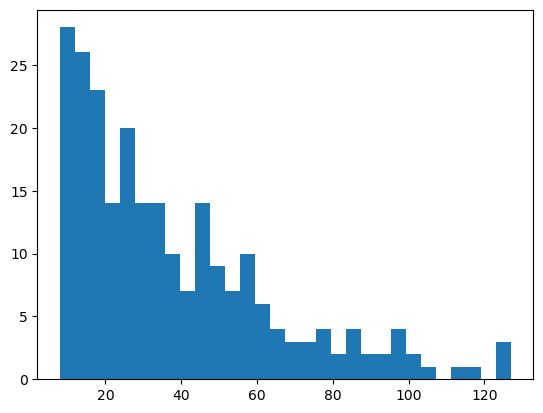

In [485]:
qq=plt.hist(object_df.loc[validrows].npix, bins=30)

In [469]:
def pairing2reg(obj_df,  obj_hat, ref_df, ref_index, reg_path, nameroot='Pair'):
    reghdr =[ '# Region file format: DS9 version 4.1',
            'global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
        'physical']
    n =  len(ref_index)

    with open(reg_path, 'w') as reg:
        for hdr in reghdr:
            reg.write(hdr+'\n')
        for i in range(n):
            title = '{' + f'{nameroot}_{i:03d}' + '}'
            circ = f'point({obj_df.iloc[i].x+1}, {obj_df.iloc[i].y+1}) # point=circle, text={title}, color=red'
            reg.write(circ+'\n')
            circ = f'point({obj_hat.iloc[i].x+1}, {obj_hat.iloc[i].y+1}) # point=circle, color=blue'
            reg.write(circ+'\n')
            line = f'line( {obj_df.iloc[i].x+1}, {obj_df.iloc[i].y+1}, {obj_hat.iloc[i].x+1}, {obj_hat.iloc[i].y+1} ) # line=0 1, color=red'
            reg.write(line+'\n')
            line = f'line( {obj_hat.iloc[i].x+1}, {obj_hat.iloc[i].y+1},'\
                f'{ref_df.iloc[ref_index.iloc[i]].x+1}, {ref_df.iloc[ref_index.iloc[i]].y+1}) # line=0 1, color=blue'
            reg.write(line+'\n')
            circ = f'point({ref_df.iloc[ref_index.iloc[i]].x+1}, {ref_df.iloc[ref_index.iloc[i]].y+1}) # point=circle, color=green'
            reg.write(circ+'\n')

## Variables

|Variable|Meaning|
|--------|-------|
|`obj_df` | object extracted from the image|
|`obj_hat` | where the objects should be according to the model|
|`ref_df` | reference objects data base|
|`ref_index` | len(obj_df), index info ref_df; maps from obj_df to ref_df, which ref_df corresponds to each obj_df|


## Functions
### `update_model`
computes new transformation, new flux model, predictions for position and flux
### `score`
computes score given `obj_hat`, `ref_df`, `ref_index`
### `update_pairing`
given hat dataframe, computes 'best' partner for each row of data frame, returns a `ref_index`
### `optimize pairing`
iterates till RMSE doesn't change
### `initialize`
creates an initial `ref_index`


In [496]:
def RMSE(xy_hat, xy_act):
    err = (xy_act - xy_hat)**2
    resid2 = err.sum(axis=1)
    rmse = np.sqrt(resid2.mean())
    return rmse

def initial_transform(dirs, detector):

    coo_path = os.path.join(dirs['coord_maps'], detector+'.coo')

    coo_df = coo2df(coo_path)
    src = np.array([coo_df.x_in, coo_df.y_in]).T
    dst = np.array([coo_df.x_ref, coo_df.y_ref]).T

    tran = sk.transform.estimate_transform('polynomial', src, dst, 3)

    return tran

def apply_transform(tran, obj_df):
    src = np.array([obj_df.x, obj_df.y]).T
    xy_hat = tran(src)
    return xy_hat

def get_ref_df(dirs, inpath, minmag = 18.5):
    img_path = os.path.basename(inpath)
    img_name = os.path.splitext(img_path)[0]
    x_tbl_path = os.path.join(dirs['xmatch_tables'], img_name+'.xml')
    x_tbl = Table.read(x_tbl_path)
    valid_rows = x_tbl['phot_g_mean_mag'] <= minmag
    ref_df = x_tbl[valid_rows].to_pandas()
    #adjust for python indexing:
    ref_df.x -= 1
    ref_df.y -= 1
    return ref_df

def find_objects(img, exp_time, thresh = 250, npix_pctile=(10,90), border_margin=32):

    bkg = sep.Background(img)
    bkg_img = bkg.back() #2d array of background

    img_noback = img - bkg
    objects = sep.extract(img_noback, thresh=thresh, err = bkg.globalrms)
    objects_df = pd.DataFrame(objects)
    objects_df.flux /= exp_time
    objects_df['obj_id'] = [f'obj_{i:04d}' for i in range(len(objects_df))]

    # lose the extreme values
    pctile = np.percentile(objects_df.npix, npix_pctile)
    valid_npix = np.logical_and(objects_df.npix >= pctile[0], objects_df.npix<= pctile[1])

    # lose the objects too close to the edge
    imgshape = img.shape
    x_ok = np.logical_and(objects_df.x > border_margin, objects_df.x < imgshape[1]-border_margin)
    y_ok = np.logical_and(objects_df.y > border_margin, objects_df.y < imgshape[0]-border_margin)
    valid_pos = np.logical_and(x_ok, y_ok)

    #combine the criteria:
    valid_rows = np.logical_and(valid_npix, valid_pos)

    return objects_df.loc[valid_rows]

def find_closest_ref(  obj_hat_ser, ref_df, flux_col = 'phot_g_mean_flux'):
    # get the pixel distance from point to each ref
    pix_dist2 = (ref_df.x-obj_hat_ser.x)**2 + (ref_df.y-obj_hat_ser.y)**2

    # get the flux distance from point to each ref
    flux_dist = np.sqrt((ref_df[flux_col] - obj_hat_ser.flux)**2)

    # score is the product of the two
    score = pix_dist2*flux_dist

    # find and return the index of the lowest score
    indx = score.argmin()
    return indx

def find_pairs(obj_hat, ref_df):
    """
    for each row in obj_hat, find the closest match in ref_df
    """
    pair_indx = pd.Series([find_closest_ref(r[1], ref_df) for r in obj_hat.iterrows()],
                          index = obj_hat.index)
    return pair_indx

def initialize(dirs, fitspath, thresh=250.0):
    # get the image
    with fits.open(fitspath) as f:
        img_hdr = f[0].header.copy()
        img_data = f[0].data.copy()
    img_data = img_data.astype(float)
    
    #extract the objects out of the image:
    obj_df = find_objects(img_data, img_hdr['EXPTIME'], thresh=thresh)

    #get the initial transform and apply it
    tran = initial_transform(dirs, img_hdr['DETECTOR'])
    xy_hat = apply_transform( tran, obj_df)

    #intialize the flux model with parameters from earlier analysis
    flux_hat = 3690.1804746983726 + 0.8374108011606967*obj_df.flux

    # Build the data frame with the model estimates
    obj_hat = pd.DataFrame({'x':xy_hat[:,0],'y':xy_hat[:,1], 'flux': flux_hat})

    # get the reference data frame:
    ref_df = get_ref_df(dirs, fitspath)
    
    # find the intial matches
    ref_index = find_pairs(obj_hat,  ref_df)

    return obj_df, obj_hat, ref_df, ref_index



In [497]:
dirs = obs_dirs('/home/kevin/Documents/M8new/', 'N-A-L671')
dirs['region'] =  os.path.join('/home/kevin/Documents/M8new/', 'N-A-L671','region')
img_name = 'SUPA01566780'
fits_path = os.path.join(dirs['no_bias'], img_name+'.fits')
reg_path = os.path.join(dirs['region'],img_name+'_initial.reg')
obj_df, obj_hat, ref_df, ref_index = initialize(dirs,fits_path)
pairing2reg(obj_df,  obj_hat, ref_df, ref_index, reg_path)

In [472]:
dirs['region']

KeyError: 'region'

In [463]:
len(ref_index), len(ref_index.unique())

(214, 207)

In [464]:
ref_x = np.array([ref_df.iloc[i].x for i in ref_index])
ref_y = np.array([ref_df.iloc[i].y for i in ref_index])
gflux = np.array([ref_df.iloc[i].phot_g_mean_flux for i in ref_index])
dist = np.sqrt((obj_df.x-ref_x)**2 + (obj_df.y-ref_y)**2)
xx=pd.DataFrame({'x_src':obj_df.x,'y_src':obj_df.y,
              'ref_x':ref_x, 'ref_y':ref_y, 'dist':dist,
              'flux_src':obj_df.flux, 'ref_flux':gflux})
xx

,x_src,y_src,ref_x,ref_y,dist,flux_src,ref_flux
0,745.770087,14.356975,762.812299,-3.602364,24.758329,2.113591e+05,13470.377021
1,749.537049,29.214882,749.630691,34.319531,5.105508,5.236958e+04,10386.660569
2,779.001219,54.519318,776.070361,59.989019,6.205447,3.115228e+04,17710.008648
3,787.206117,67.579529,776.070361,59.989019,13.476680,4.187046e+04,17710.008648
4,1029.799370,82.398294,1026.673104,88.448328,6.810025,1.711985e+03,5034.398169
...,...,...,...,...,...,...,...
209,1857.759507,3962.467482,1849.678334,3934.799547,28.823948,1.045929e+05,98152.144139
210,1850.484685,3968.987992,1841.798412,3940.407245,29.871565,1.255653e+04,13367.045104
211,1912.952242,3974.989206,1907.118938,3942.762440,32.750449,3.443592e+03,6365.460174
212,10.957989,1035.604672,76.232370,1178.976603,157.531760,1.623958e+07,5227.376907


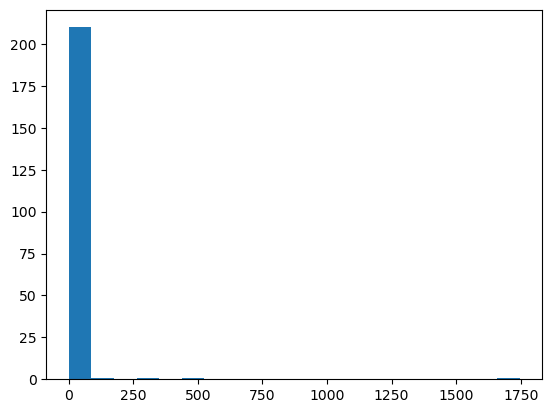

In [465]:
zz = plt.hist(xx.dist, bins=20)

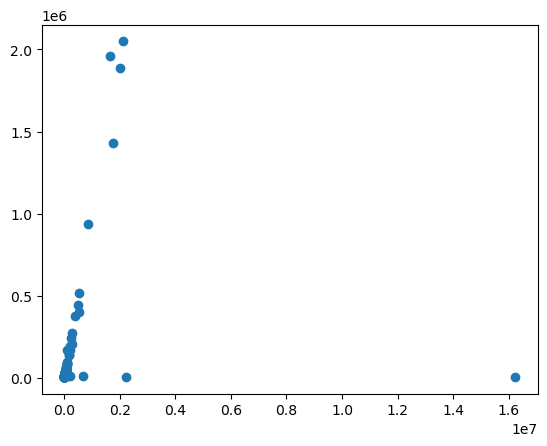

In [467]:
plt.scatter(xx.flux_src, xx.ref_flux)

In [468]:
xx.ref_flux.min()

3164.6104405096817

In [ ]:


def mod_upate(obj_df, ref_df, ref_index):
    """
    returns a new obj_hat and the model that produced it
    """
    assert len(ref_index) == len(obj_df)

    newmod = {}

    # position
    src = obj_df[['x','y']].to_numpy()
    dst = ref_df.iloc[ref_index][['x','y']].to_numpy()
    tran = sk.estimate_transform('polynomial', src, dst, order=3)
    newmod['tran'] = tran
    xy_hat = tran(src)

    # flux
    ref_flux = ref_df.iloc[ref_index].phot_g_mean_flux
    obj_flux = obj_df.flux.reshape(-1,1)
    flux_mod = LinearRegression().fit( obj_flux, ref_flux)
    newmod['flux'] = flux_mod
    flux_hat = flux_mod.predict(obj_flux)
    
    obj_hat = pd.DataFrame({'x':xy_hat[:, 0], 'y':xy_hat[:,1], 'flux':flux_hat})
    
    return newmod, obj_hat
    
def optimize_pairing(obj_df, ref_df, maxiter=15)
    """
    returns series indicating which ref_df goes with which obj_df
    """

    scores = np.full(maxiter, np.nan, dtype=np.float64)
    scores[0] = score_last_iter = np.finfo(scores.dtype).max

    for iter in range(maxiter):
        score_this_iter = score(obj_df, obj_hat, ref_df)
        if score_this_iter/score_last_iter <= converge_crit:
            break

        # compute new pairing
        ref_index =  
        # update the model
        score_last_iter = score_this_iter


def align_image(dirs, inpath, outpath, maxiter=15):


    # get the image
    with fits.open(inpath) as f:
        img_hdr = f[0].header.copy()
        img_data = f[0].data.copy()
    img_data = img_data.astype(float)

    #get the intial transform and the objects in the image
    tran = initial_transorm(dirs, img_hdr['DETECTOR'])
    obj_df = find_objects(img_data, thresh=250.0)
    obj_tbl = Table.from_pandas(obj_df)
    obj_xy = np.array([obj_df.x, obj_df.y]).T
    ref_all = get_refs(dirs, inpath, minmag=50.0)
    ref_xy = np.zeros_like(obj_xy)
    rmse = np.full(maxiter, np.nan)

    # calculate the intial pairing

    print(f'Objects found: {len(obj_df)}')

    imname = os.path.splitext(os.path.basename(inpath))[0]
    obj_tbl_path = os.path.join(dirs['region'], imname+'_objects.xml')
    obj_tbl['x'] += 1; obj_tbl['y'] += 1
    obj_tbl.write(obj_tbl_path, table_id= 'objects',format = 'votable', overwrite=True)

    for iter in range(maxiter):
        obj_hat = tran(obj_xy)
        #calculate a new pairing
        ref_xy = np.array([find_closest_ref(ref_all, obj) for obj in obj_hat])
        # score this iteration
        rmse[iter] = RMSE(obj_hat, ref_xy)

        #write the region file:
        map2reg(ref_xy,  obj_xy, obj_hat, os.path.join(dirs['region'], imname+f'_{iter:03d}.reg'), regfrac=1.0)
        # estimate the transform with the new pairing
        tran = sk.transform.estimate_transform('polynomial', obj_xy, ref_xy, 3)

    pairing2reg(obj_xy, ref_xy, os.path.join(dirs['region'], imname+'_final.reg') )
    return rmse

    # img_new = sk.transform.warp(img_data, tran, cval = np.nan)
    # img_new = img_new.astype(np.float32)

    # #write out the result
    # phdu = fits.PrimaryHDU(data = img_new, header=img_hdr)

    # phdu.writeto(outpath, overwrite=True)


In [32]:
from utils import obs_dirs
import matplotlib.pyplot as plt

Objects found: 232


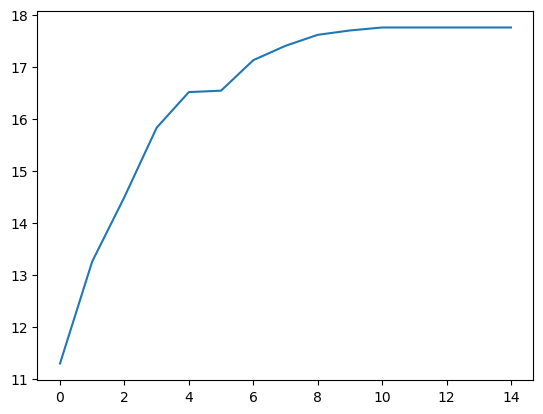

In [33]:
dirs = obs_dirs('/home/kevin/Documents/M8new/', 'N-A-L671')
dirs['region'] =  os.path.join('/home/kevin/Documents/M8new/', 'N-A-L671','region')
img_path = r'/home/kevin/Documents/M8new/N-A-L671/no_bias/SUPA01566780.fits'
rmse = align_image(dirs, img_path, None)
plt.plot(rmse)

In [34]:
tbl = Table.read(r'/home/kevin/Documents/M8new/N-A-L671/xmatch_tables/SUPA01566788.xml')

In [329]:
obj_map_path = '/home/kevin/Documents/M8new/N-A-L671/obj_map.csv'
xmatch = Table.read(obj_map_path, delimiter='\s', comment='#')
xmatch['obj_id'] = [f'obj_{i:04d}' for i in xmatch['obj']]
xmatch['GaiaId'] = [f'gaia_{i:04d}' for i in xmatch['gaia']]
xmatch

obj,gaia,obj_id,GaiaId
int64,int64,str8,str9
1,2771,obj_0001,gaia_2771
2,2755,obj_0002,gaia_2755
3,2803,obj_0003,gaia_2803
4,2754,obj_0004,gaia_2754
5,4415,obj_0005,gaia_4415
6,4083,obj_0006,gaia_4083
7,2836,obj_0007,gaia_2836
8,4426,obj_0008,gaia_4426
9,2806,obj_0009,gaia_2806


In [406]:
img_path = r'/home/kevin/Documents/M8new/N-A-L671/no_bias/SUPA01566780.fits'
exp_time = fits.getval(img_path, 'EXPTIME')

In [407]:
exp_time

120.0

In [408]:
img_path = r'/home/kevin/Documents/M8new/N-A-L671/no_bias/SUPA01566780.fits'
exp_time = fits.getval(img_path, 'EXPTIME')
obj_tbl =  Table.read('/home/kevin/Documents/M8new/N-A-L671/region/SUPA01566780_objects.xml')
gaia_tbl = Table.read('/home/kevin/Documents/M8new/N-A-L671/xmatch_tables/SUPA01566780.xml')

In [347]:
gaia_tbl.meta

{'ID': 'xmatch'}

In [294]:
from astropy.table import join

In [409]:
xx=join(xmatch, gaia_tbl)
# xx.add_index('GaiaID')
# xmatch_tbl = join(xx, gaia_tbl, keys='GaiaID')
'GaiaId' in xx.columns, 'GaiaId' in gaia_tbl.columns, 'GaiaId' in xmatch.columns


(True, True, True)

In [410]:
xmatch_tbl = join(xx, obj_tbl, keys='obj_id')

In [411]:
from sklearn.linear_model import LinearRegression
obs_flux = xmatch_tbl['flux']/exp_time
gaia_flux = xmatch_tbl['phot_g_mean_flux']
mod = LinearRegression().fit( obs_flux.reshape(-1,1), gaia_flux)
y_hat = mod.predict(obs_flux.reshape(-1,1))
rsq = mod.score( obs_flux.reshape(-1,1), gaia_flux)
mod_rmse = np.sqrt(((gaia_flux - y_hat)**2).mean())
mod_nrmse = mod_rmse/gaia_flux.mean()
zz = np.linspace(obs_flux.min(),obs_flux.max(), 10000).reshape(-1,1)
fitted = mod.predict(zz)

In [412]:
mod.intercept_,mod.coef_[0], rsq

(3690.1804746983726, 0.8374108011606967, 0.969109026730168)

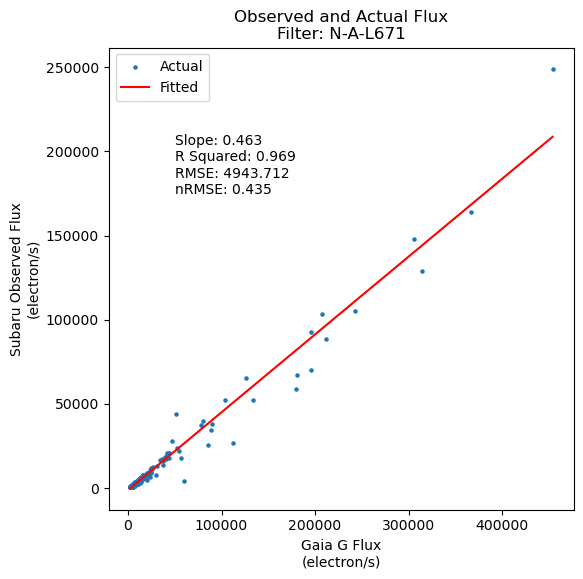

In [390]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(xmatch_tbl['phot_g_mean_flux'], obs_flux, s=5, label='Actual')
ax.plot(zz, fitted, color='red', label='Fitted')
ax.set_ylabel('Subaru Observed Flux\n(electron/s)')
ax.set_xlabel('Gaia G Flux\n(electron/s)')
ax.set_title('Observed and Actual Flux\nFilter: N-A-L671')
ax.text(50000, 175000, f'Slope: {mod.coef_[0]:.3f}\nR Squared: {rsq:.3f}'
        f'\nRMSE: {mod_rmse:.3f}\nnRMSE: {mod_nrmse:.3f}')
ax.legend()

In [337]:
max_obs_flux = 30000.0

obs_flux = xmatch_tbl['flux']/300
g_flux = xmatch_tbl['phot_g_mean_flux']

valid_flux = obs_flux <= max_obs_flux
obs_flux = obs_flux[valid_flux]
g_flux = g_flux[valid_flux]


mod = LinearRegression().fit(g_flux.reshape(-1,1), obs_flux)
y_hat = mod.predict(g_flux.reshape(-1,1))
rsq = mod.score(g_flux.reshape(-1,1), obs_flux)
mod_rmse = np.sqrt(((obs_flux - y_hat)**2).mean())
mod_nrmse = mod_rmse/obs_flux.mean()
zz = np.linspace(g_flux.min(),g_flux.max(), 10000).reshape(-1,1)
fitted = mod.predict(zz)

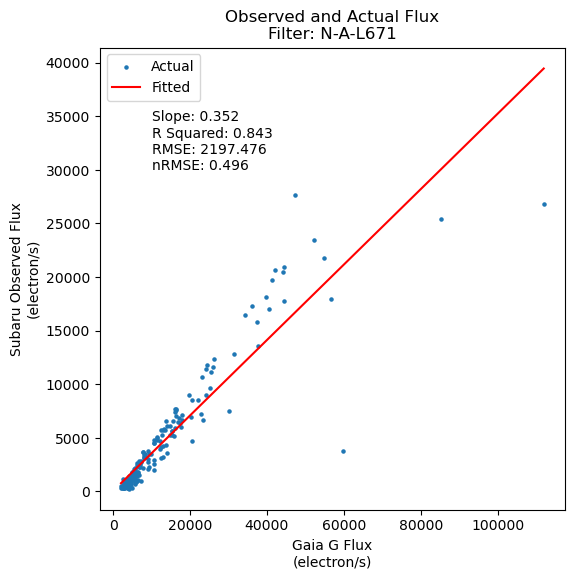

In [338]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(g_flux, obs_flux, s=5, label='Actual')
ax.plot(zz, fitted, color='red', label='Fitted')
ax.set_ylabel('Subaru Observed Flux\n(electron/s)')
ax.set_xlabel('Gaia G Flux\n(electron/s)')
ax.set_title('Observed and Actual Flux\nFilter: N-A-L671')
ax.text(10000, 30000, f'Slope: {mod.coef_[0]:.3f}\nR Squared: {rsq:.3f}'
        f'\nRMSE: {mod_rmse:.3f}\nnRMSE: {mod_nrmse:.3f}')
ax.legend()

In [320]:
xmatch_tbl.columns

<TableColumns names=('obj','gaia','obj_id','GaiaId','source_id','ra','dec','parallax','pmra','pmdec','radial_velocity','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_mean_flux','phot_bp_mean_flux','phot_rp_mean_flux','r_est','RA_MJD','DEC_MJD','x_1','y_1','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x_2','y_2','x2','y2','xy','errx2','erry2','errxy','a','b','theta','cxx','cyy','cxy','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag')>

In [360]:
src = np.array([xmatch_tbl['x_2'],xmatch_tbl['y_2']]).T
dst = np.array([xmatch_tbl['x_1'],xmatch_tbl['y_1']]).T

In [356]:

img_path = r'/home/kevin/Documents/M8new/N-A-L671/no_bias/SUPA01566780.fits'

for degree in range(4):
    out_path = f'/home/kevin/Documents/M8new/N-A-L671/registered_image/SUPA01566780_{degree:02d}.fits'
    warp_image(img_path, out_path, degree=degree, src=src, dst=dst) #coo_maps='/home/kevin/repos/ReipurthBallyProject/SubaruCoordinateMaps')

In [382]:
detector = 'nausicaa'
coo_path = os.path.join(coo_maps, detector+'.coo')
coo_df = coo2df(coo_path)

In [387]:
src = np.array([coo_df.x_in, coo_df.y_in]).T
dst = np.array([coo_df.x_ref, coo_df.y_ref]).T
out_path = f'/home/kevin/Documents/M8new/N-A-L671/registered_image/SUPA01566780_orig.fits'
warp_image(img_path, out_path, degree=3, src=src, dst=dst) #coo_maps='/home/kevin/repos/ReipurthBallyProject/SubaruCoordinateMaps')

In [361]:
for degree in range(1,6):
    tran = sk.transform.estimate_transform('polynomial', src, dst, order=degree)
    resid = tran.residuals(src, dst)
    rmse = np.sqrt((resid**2).mean())
    print(f'Degree: {degree}, RMSE: {rmse:.3f}')

Degree: 1, RMSE: 7.157
Degree: 2, RMSE: 7.497
Degree: 3, RMSE: 11.724
Degree: 4, RMSE: 20.588
Degree: 5, RMSE: 2120.481


In [342]:
resid.max(), resid.argmax()

(55.730545235465414, 12)

In [343]:
resid

array([23.11945216, 36.4559486 , 11.81758591, 41.25627696,  7.52046214,
        9.10227467, 45.21020529,  5.65237679, 14.61220808,  7.5771336 ,
        9.83954194,  4.1890069 , 55.73054524,  2.39284768, 35.16554383,
        4.5286886 , 52.84612251,  3.54534899, 15.69038597,  8.02556486,
        5.6743019 , 11.39007674,  4.40496796, 29.78785712,  3.81019602,
        8.23989252,  6.16645873, 24.7786146 , 14.71944937,  6.86258921,
        5.38541717,  4.69941099,  9.78882987, 21.80609669, 27.83780752,
        9.24591933, 10.1574221 ,  3.21617412, 10.56986902, 19.2437774 ,
       12.37072937,  0.94267459,  3.37134045, 14.55539447, 14.98202439,
       11.15395735, 12.46983162, 14.53105426,  6.56060311,  4.77664402,
        7.6036999 , 11.5137836 ,  3.04142641, 11.72717195, 13.57869764,
        7.89269797,  7.53225061, 12.05414301, 17.33290184,  4.15000505,
        3.76173168,  6.65134327,  7.38162198,  6.5289372 ,  4.64714502,
        5.19701411,  1.40987561,  5.34282456,  9.51656968, 11.44

In [344]:
src = np.array([xmatch_tbl['x_2'],xmatch_tbl['y_2']]).T
dst = np.array([xmatch_tbl['x_1'],xmatch_tbl['y_1']]).T
off2= (src-dst)**2
dists = np.sqrt(off2.sum(axis=1))
xmatch_tbl['Distance'] = dists
ndx = dists.argmax()
print(f'Distance: {dists[ndx]:.2f}, index: {ndx}')

Distance: 84.76, index: 223


In [345]:
xmatch_tbl[ndx]

obj,gaia,obj_id,GaiaId,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,r_est,RA_MJD,DEC_MJD,x_1,y_1,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x_2,y_2,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,Distance
,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,str8,str9,int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64
229,2647,obj_0229,gaia_2647,4066043619307330944,270.5936422175172,-24.152006996975,0.4900445089672835,-1.2775950779798508,-8.961473836696458,--,16.44605,17.254313,15.512073,4971.946712757077,1712.7423940973601,4946.854034148886,2040.6309665776955,270.59358748807057,-24.15239953109631,1906.413537183059,4084.230052287745,12663.7099609375,6,6,1950,1951,4154,4156,1951.503326345807,4156.004827233616,0.24998893542357187,0.6377334141231203,-0.007908687943480763,5.364387546681602e-07,1.4304900354955495e-06,3.4452967145210556e-11,0.7986831068992615,0.49982765316963196,-1.5504109859466553,4.001747131347656,1.5686687231063843,0.09925328940153122,84706.375,97141.1953125,15438.5146484375,17900.36328125,1951,4155,1951,4155,0,84.76265336379899


In [346]:
cols = ['obj_id', 'GaiaId', 'Distance']
xmatch_tbl.sort('Distance', reverse=True)
xmatch_tbl[cols][:20]

obj_id,GaiaId,Distance
str8,str9,float64
obj_0229,gaia_2647,84.76265336379899
obj_0226,gaia_2330,76.0542344845211
obj_0225,gaia_2276,74.90154502600922
obj_0222,gaia_2273,74.00291280969704
obj_0213,gaia_2237,73.34418909839138
obj_0204,gaia_2167,69.54922081049885
obj_0218,gaia_2189,68.29155387471141
obj_0216,gaia_2274,65.68952498576363
obj_0227,gaia_2317,64.7211998118058


In [279]:
coo_maps = '/home/kevin/repos/ReipurthBallyProject/SubaruCoordinateMaps'
for detector in ['nausicaa.coo']:
    coo_path = os.path.join(coo_maps, detector)
    coo_df = coo2df(coo_path)
    src = np.array([coo_df.x_in, coo_df.y_in]).T
    dst = np.array([coo_df.x_ref, coo_df.y_ref]).T
    tran = sk.transform.estimate_transform('polynomial', src,dst, 3)
    resid = tran.residuals(src, dst)
    rmse = np.sqrt((resid**2).mean())
    print(f'Detector: {detector}, Number of  RMSE: {rmse}')

Detector: nausicaa.coo, Number of  RMSE: 1.1590773423714407


In [280]:
resid

array([1.3440902 , 0.636933  , 0.70922539, 1.12447224, 0.19656326,
       0.77386843, 1.75414895, 1.01072144, 0.31726802, 0.07278188,
       0.34111454, 1.43377423, 0.7115632 , 0.77356316, 2.20890001,
       1.4817619 , 1.2234361 , 0.93549607, 2.42893444, 1.25273316,
       0.5040395 , 1.06858764, 1.28427304, 1.4086789 , 0.6194247 ,
       0.8228082 , 0.82269698, 0.98577224, 0.37987198, 0.38027315,
       0.63857292, 0.28632867, 0.57344964, 1.34964116, 0.68606098,
       1.98049827, 0.82304264, 1.45766523, 0.79572563, 0.11876619,
       0.70049311, 0.90024538, 1.17367369, 1.67503353, 2.11808465,
       0.449803  , 1.58075045, 0.26578342, 0.33384981, 1.31508445,
       2.53144929])

In [285]:
off2= (src-dst)**2
dist2 = np.sqrt(off2.sum(axis=1))
dist2.sort()
dist2

array([ 6.95369525,  8.11828741,  8.432632  ,  9.08221972,  9.54041904,
       10.25870724, 10.25870724, 10.79901739, 10.79901739, 10.79901739,
       11.31354693, 11.92550436, 11.92550436, 11.92557507, 13.17213332,
       13.17214997, 23.07517108, 24.37007807, 24.62088554, 24.62091513,
       25.3584813 , 26.38753015, 27.15246165, 28.11588302, 28.11596939,
       28.62122743, 28.62122884, 28.76398653, 28.97678482, 30.62606096,
       30.892417  , 31.41823959, 32.44448114, 32.63320378, 32.94550467,
       34.46447144, 36.65304986, 36.9313674 , 37.31744031, 47.59893924,
       49.93210332, 51.07819957, 51.07820116, 51.52297051, 51.88128442,
       69.95112815, 70.21543132, 72.65759062, 72.83732749, 76.40541619,
       80.77814982])

In [268]:
xmatch_tbl[:2]

obj,gaia,obj_id,GaiaId,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,r_est,RA_MJD,DEC_MJD,x_1,y_1,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x_2,y_2,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,str8,str9,int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
1,2771,obj_0001,gaia_2771,4066019597532160640,270.64686339766314,-24.373221093650276,2.0018252201751165,-0.47891786862956603,-11.729845042367296,--,16.522076,17.39112,15.500379,4635.713389387472,1509.9703953894975,5000.423591614373,499.5441110051164,270.6468475194534,-24.373736602468757,1032.9723362874156,141.23533842114728,12663.7099609375,18,16,1019,1023,141,144,1021.7292893319351,143.4918537174976,1.367072654498128,1.0224742474110307,-0.00768812062378732,5.019149526389222e-07,3.3029607327965273e-07,1.145498383214586e-10,1.1692920923233032,1.0110899209976196,-0.02229558862745762,0.73152095079422,0.9780610799789429,0.011000807397067547,399078.9375,440438.96875,33580.875,41761.86328125,1021,142,1021,142,0
2,2755,obj_0002,gaia_2755,4066019533130570112,270.6778924634641,-24.366947670627912,1.0535055998097655,-2.6619230651726475,-0.3980124317116792,34.35718,14.144041,14.537588,13.573222,41431.483942727704,20911.326955480952,29503.22463090857,949.2118505877642,270.67777012882135,-24.36695979373863,531.174014832679,262.8862619033626,12663.7099609375,78,70,502,511,251,260,507.6939188083178,256.7394642595332,3.18239142056893,3.8826969457907197,0.03167911255053113,3.6433662691693833e-08,3.620870153413762e-08,4.2263847940495817e-10,1.9708188772201538,1.783524990081787,1.525683045387268,0.31425461173057556,0.25757384300231934,-0.00512803765013814,5846763.0,5916600.5,198793.65625,200953.34375,507,256,507,256,0


In [269]:
row = xmatch_tbl['obj_id'] == 'obj_0108'
xmatch_tbl[row]

obj,gaia,obj_id,GaiaId,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,r_est,RA_MJD,DEC_MJD,x_1,y_1,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x_2,y_2,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,str8,str9,int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
108,5386,obj_0108,gaia_5386,4066033208306504064,270.647394814581,-24.261102769193226,0.6437017469616684,2.176462934945411,-2.0533573515126506,-21.11494,15.182337,17.018452,13.898112,15922.533406593297,2128.3155829333864,21873.239954922137,1553.5145037590657,270.6475083361875,-24.261188427890165,1025.949075511825,2147.120748321123,12663.7099609375,39,37,1022,1028,2159,2165,1026.2111378048717,2162.745301223797,2.1573578715417714,2.1568078599844336,-0.13271708734027854,1.408436308715484e-07,1.4125904892249683e-07,-1.3740367891017554e-08,1.5132086277008057,1.4228019714355469,-0.7843620777130127,0.465291291475296,0.4654099643230438,0.05726250261068344,1482432.625,1545469.625,86302.7421875,105951.2734375,1025,2162,1025,2162,0
